# Autoregression

In [1]:
import warnings
warnings.filterwarnings("ignore")

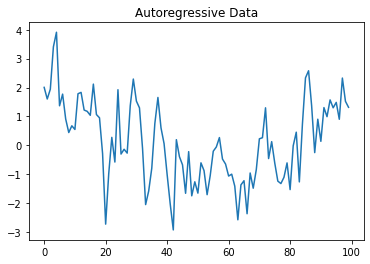

ADF Statistic: -4.202944
p-value: 0.000651


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Generate autoregressive data
np.random.seed(0)
n_samples = 100
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]

plt.plot(x)
plt.title("Autoregressive Data")
plt.show()

# Check for stationarity
result = adfuller(x)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [3]:
from statsmodels.tsa.ar_model import AutoReg
from itertools import product

# Define a range of lag values
max_lag = 10
lags = range(1, max_lag + 1)

# Find the best model (the one with the lowest AIC)
best_aic, best_order = np.inf, None

for lag in lags:
    model = AutoReg(x, lags=lag)
    result = model.fit()
    if result.aic < best_aic:
        best_aic = result.aic
        best_order = lag

print(f'Best model: AR({best_order}), AIC = {best_aic}')

Best model: AR(6), AIC = 0.03749352317181506


In [4]:
# Fit the best model
model = AutoReg(x, lags=best_order)
result = model.fit()

# Print the summary
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  100
Model:                     AutoReg(6)   Log Likelihood                -127.142
Method:               Conditional MLE   S.D. of innovations              0.936
Date:                Fri, 15 Mar 2024   AIC                              0.037
Time:                        17:57:57   BIC                              0.254
Sample:                             6   HQIC                             0.125
                                  100                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0091      0.097     -0.094      0.925      -0.198       0.180
y.L1           0.5958      0.101      5.890      0.000       0.398       0.794
y.L2           0.1329      0.115      1.157      0.2